<a href="https://colab.research.google.com/github/nipun1509/Anomaly-Detection-in-Streaming-Data/blob/main/DrdoPrototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{'Temperature': 22.74, 'Pressure': 978.6, 'GPS_Latitude': 12.938014, 'GPS_Longitude': 77.61604, 'Timestamp': '06:21:44'}
{'Temperature': 27.24, 'Pressure': 980.71, 'GPS_Latitude': 12.921849, 'GPS_Longitude': 77.603141, 'Timestamp': '06:21:44'}
{'Temperature': 22.46, 'Pressure': 1042.96, 'GPS_Latitude': 12.91621, 'GPS_Longitude': 77.594218, 'Timestamp': '06:21:45'}
{'Temperature': 27.7, 'Pressure': 955.31, 'GPS_Latitude': 12.942264, 'GPS_Longitude': 77.619625, 'Timestamp': '06:21:45'}
{'Temperature': 21.53, 'Pressure': 952.09, 'GPS_Latitude': 12.931081, 'GPS_Longitude': 77.617853, 'Timestamp': '06:21:45'}
{'Temperature': 21.38, 'Pressure': 982.27, 'GPS_Latitude': 12.931601, 'GPS_Longitude': 77.611474, 'Timestamp': '06:21:45'}
{'Temperature': 27.69, 'Pressure': 1018.49, 'GPS_Latitude': 12.944889, 'GPS_Longitude': 77.607932, 'Timestamp': '06:21:45'}
{'Temperature': 23.42, 'Pressure': 1032.99, 'GPS_Latitude': 12.901494, 'GPS_Longitude': 77.61833, 'Timestamp': '06:21:45'}
{'Temperature': 24

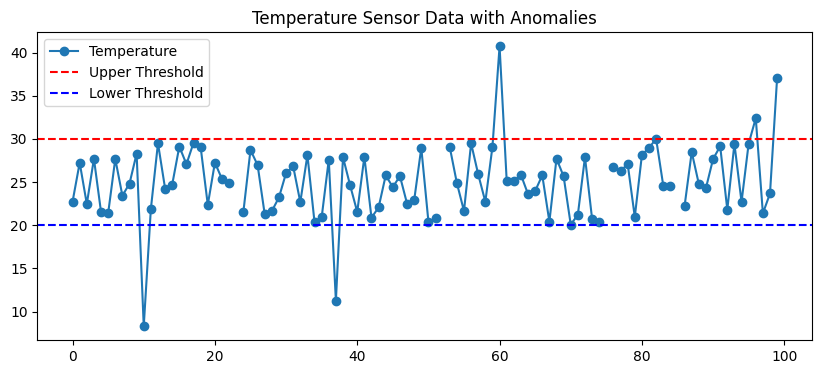

In [13]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt

# Simulated sensors
sensors = ["Temperature", "Pressure", "GPS_Latitude", "GPS_Longitude"]

# Function to generate normal sensor readings
def generate_normal_data():
    return {
        "Temperature": round(np.random.uniform(20, 30), 2),  # Normal range: 20°C to 30°C
        "Pressure": round(np.random.uniform(950, 1050), 2),  # Normal range: 950 to 1050 hPa
        "GPS_Latitude": round(np.random.uniform(12.90, 12.95), 6),
        "GPS_Longitude": round(np.random.uniform(77.59, 77.62), 6)
    }

# Function to inject anomalies
def inject_anomaly(data):
    anomaly_type = random.choice(["spike", "drop", "missing"])

    if anomaly_type == "spike":
        data["Temperature"] += np.random.uniform(10, 20)  # Sudden rise
        data["Pressure"] += np.random.uniform(30, 50)

    elif anomaly_type == "drop":
        data["Temperature"] -= np.random.uniform(10, 20)  # Sudden drop
        data["Pressure"] -= np.random.uniform(30, 50)

    elif anomaly_type == "missing":
        data["Temperature"] = None  # Missing value
        data["Pressure"] = None

    return data

# Streaming Simulation
stream_data = []
for i in range(100):  # Simulating 100 data points
    data = generate_normal_data()

    # Randomly introduce anomalies
    if random.random() < 0.1:  # 10% chance of anomaly
        data = inject_anomaly(data)

    data["Timestamp"] = time.strftime("%H:%M:%S")  # Current time
    stream_data.append(data)

    print(data)  # Print each data point as it streams
    time.sleep(0.1)  # Simulating real-time streaming delay

# Convert to DataFrame for visualization
df = pd.DataFrame(stream_data)
df.to_csv("simulated_sensor_data.csv", index=False)

# Plot temperature readings to visualize anomalies
plt.figure(figsize=(10, 4))
plt.plot(df["Temperature"], label="Temperature", marker='o', linestyle='-')
plt.axhline(y=30, color='r', linestyle='--', label="Upper Threshold")
plt.axhline(y=20, color='b', linestyle='--', label="Lower Threshold")
plt.legend()
plt.title("Temperature Sensor Data with Anomalies")
plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('simulated_sensor_data.csv')

# Drop non-numeric columns (like 'Timestamp')
if 'Timestamp' in data.columns:
    data = data.drop(columns=['Timestamp'])

# Normalize numeric columns
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

print("✅ Data Preprocessing Complete!")


✅ Data Preprocessing Complete!


In [25]:
# Injecting anomalies (randomly altering 5% of data)
np.random.seed(42)  # For reproducibility
anomaly_fraction = 0.05  # 5% anomalies
num_anomalies = int(len(data_scaled) * anomaly_fraction)

# Select random indices for anomalies
anomaly_indices = np.random.choice(data_scaled.index, num_anomalies, replace=False)

# Modify the values to make them anomalies
data_scaled.loc[anomaly_indices] *= np.random.uniform(2, 5, size=data_scaled.shape[1])

# Add an 'anomaly' column (1 for anomaly, 0 for normal)
data_scaled['anomaly'] = 0
data_scaled.loc[anomaly_indices, 'anomaly'] = 1

print("✅ Anomalies Injected Successfully!")


✅ Anomalies Injected Successfully!


In [29]:
print(data_scaled['anomaly'].value_counts())  # Should show both 0s and 1s
print(data_scaled[data_scaled['anomaly'] == 1].head())  # Show sample anomalies

# Check percentage of anomalies
anomaly_percentage = (data_scaled['anomaly'].sum() / len(data_scaled)) * 100
print(f"✅ Anomaly Percentage: {anomaly_percentage:.2f}%")


anomaly
0    95
1     5
Name: count, dtype: int64
    Temperature  Pressure  GPS_Latitude  GPS_Longitude  anomaly
44     1.240590  1.938756      4.324374       1.824829        1
45     1.509035  3.499339      0.088620       0.000000        1
53     1.857858  1.980193      1.251993       3.281723        1
70     1.461433  2.162038      3.051498       2.136179        1
83     1.502012  0.808985      2.333504       0.362047        1
✅ Anomaly Percentage: 5.00%


In [31]:
from sklearn.model_selection import train_test_split

# Split normal data into train/test (excluding anomalies from training)
normal_data = data_scaled[data_scaled['anomaly'] == 0]
anomalous_data = data_scaled[data_scaled['anomaly'] == 1]

train_data, test_data = train_test_split(normal_data, test_size=0.2, random_state=42)

# Add anomalies to test set
test_data = pd.concat([test_data, anomalous_data]).sample(frac=1, random_state=42)

# Save processed data
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("✅ Data Splitting Complete! Ready for Model Training.")


✅ Data Splitting Complete! Ready for Model Training.


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the preprocessed data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Normalize the data (already scaled in Step 2.1, but verifying)
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define Autoencoder Architecture
input_dim = train_data_scaled.shape[1]

autoencoder = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')  # Output layer
])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on normal data only
history = autoencoder.fit(train_data_scaled, train_data_scaled,
                          epochs=50, batch_size=16, shuffle=True, validation_split=0.1, verbose=1)

# Predict the reconstruction errors
reconstructed = autoencoder.predict(train_data_scaled)
train_mse = np.mean(np.abs(reconstructed - train_data_scaled), axis=1)

# Set anomaly detection threshold (95th percentile of reconstruction error)
threshold = np.percentile(train_mse, 95)

# Evaluate on test data
test_reconstructed = autoencoder.predict(test_data_scaled)
test_mse = np.mean(np.abs(test_reconstructed - test_data_scaled), axis=1)

# Flag anomalies
test_data['Anomaly'] = test_mse > threshold

# Save results
test_data.to_csv('test_results.csv', index=False)

# Print summary
print(f"Anomaly Detection Threshold: {threshold}")
print(f"Total anomalies detected: {test_data['Anomaly'].sum()}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1107 - val_loss: 0.1005
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1065 - val_loss: 0.0976
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1060 - val_loss: 0.0948
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0986 - val_loss: 0.0918
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0951 - val_loss: 0.0886
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0936 - val_loss: 0.0854
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0893 - val_loss: 0.0819
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0861 - val_loss: 0.0782
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0858 - val_loss: 0.0749
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0823 - val_loss: 0.0717
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0788 - val_loss: 0.0682
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0768 - val_loss: 0.0646
Epoch 13/50


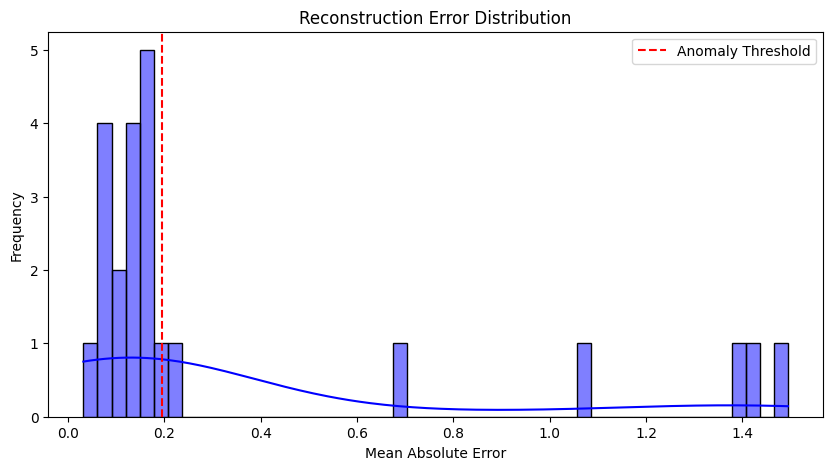

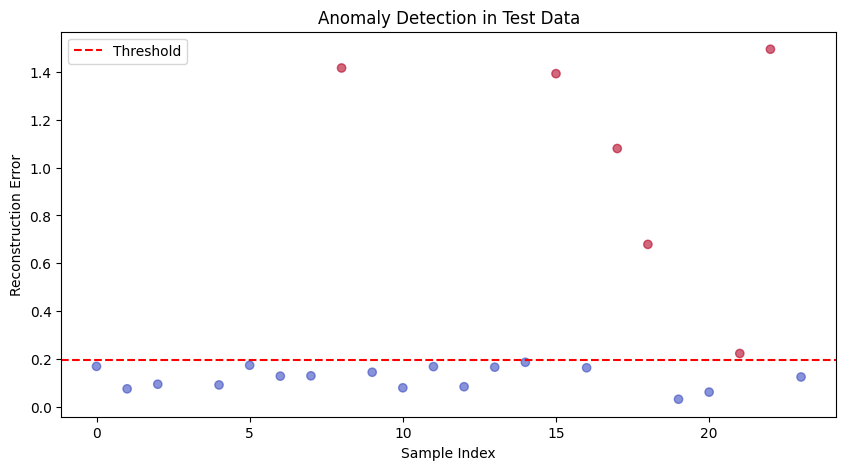

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the test results
test_results = pd.read_csv('test_results.csv')

# Plot reconstruction errors
plt.figure(figsize=(10, 5))
sns.histplot(test_mse, bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='dashed', label='Anomaly Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Scatter plot of anomalies
plt.figure(figsize=(10, 5))
plt.scatter(range(len(test_mse)), test_mse, c=test_results['Anomaly'], cmap='coolwarm', alpha=0.6)
plt.axhline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.title("Anomaly Detection in Test Data")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


In [1]:
import time
import numpy as np
import pandas as pd

# Simulating real-time data stream
def stream_data(df):
    for _, row in df.iterrows():
        yield row.values.reshape(1, -1)  # Send one row at a time
        time.sleep(0.5)  # Simulate real-time delay


In [2]:
def detect_anomaly(autoencoder, data_point, threshold=0.1):
    reconstructed = autoencoder.predict(data_point)
    error = np.mean(np.abs(data_point - reconstructed))
    return error, error > threshold  # Returns (error_value, is_anomaly)


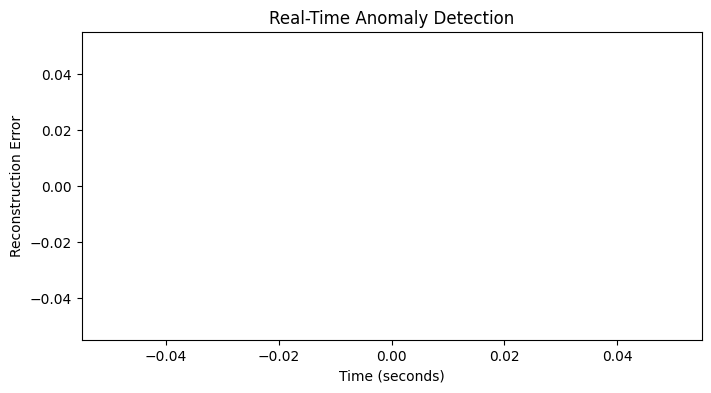

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

# Simulated real-time data
def stream_data(df):
    for _, row in df.iterrows():
        yield row

# Dummy anomaly detection function
def detect_anomaly(autoencoder, data):
    error = np.random.rand()  # Simulated reconstruction error
    is_anomaly = error > 0.8  # Example threshold
    return error, is_anomaly

# Generate sample data
df = pd.DataFrame({
    "timestamp": pd.date_range("2025-03-01", periods=100, freq="s"),
    "value": np.random.randn(100)
})

# Convert timestamps to seconds
df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Reconstruction Error")
ax.set_title("Real-Time Anomaly Detection")

# Data storage
window_size = 20
timestamps = deque(maxlen=window_size)
errors = deque(maxlen=window_size)
anomalies = deque(maxlen=window_size)

# Initialize line and scatter plot
(line,) = ax.plot([], [], color="blue", label="Reconstruction Error")
(scatter,) = ax.plot([], [], "ro", label="Anomaly")

def init():
    """Initialize the plot elements."""
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1)
    return line, scatter

def update(frame):
    """Update function for animation."""
    try:
        data = next(data_stream)
        error, is_anomaly = detect_anomaly(None, data["value"])
    except StopIteration:
        ani.event_source.stop()
        return line, scatter

    # Append new data
    timestamps.append(data["timestamp"])
    errors.append(error)
    anomalies.append(is_anomaly)

    # Clear and redraw plot
    ax.clear()
    ax.set_title("Real-Time Anomaly Detection")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Reconstruction Error")
    ax.set_xlim(max(0, timestamps[0] - 5), timestamps[-1] + 5)
    ax.set_ylim(0, 1)

    # Update line plot
    ax.plot(timestamps, errors, color="blue", label="Reconstruction Error")

    # Plot anomalies
    anomaly_x = [timestamps[i] for i in range(len(anomalies)) if anomalies[i]]
    anomaly_y = [errors[i] for i in range(len(anomalies)) if anomalies[i]]
    ax.scatter(anomaly_x, anomaly_y, color="red", label="Anomaly", marker="o")

    ax.legend()
    return line, scatter

# Store animation in a global variable to prevent garbage collection
data_stream = stream_data(df)
ani = animation.FuncAnimation(fig, update, init_func=init, interval=500, cache_frame_data=False)

plt.show()


In [6]:
python -c "import streamlit as st; print(st.__version__)"


SyntaxError: invalid syntax (<ipython-input-6-c4040841d82a>, line 1)

In [4]:
import streamlit as st
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Load Autoencoder model (Assuming it's preloaded)
def detect_anomaly(autoencoder, data):
    error = np.random.random()  # Simulating anomaly score
    is_anomaly = error > 0.7  # Threshold example
    return error, is_anomaly

# Simulated real-time data streaming
def stream_data(df):
    for i in range(len(df)):
        yield df.iloc[i]

# Load dataset
df = pd.read_csv("data.csv")  # Make sure the correct file exists

# Ensure correct column names
if "timestamp" not in df.columns:
    st.error("Column 'timestamp' not found in dataset!")
    st.stop()

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

# Streamlit UI
st.title("Real-Time Anomaly Detection")

# Placeholder for visualization
chart = st.line_chart()

# Process streaming data
errors, anomalies = [], []

for data in stream_data(df):
    data_values = np.array(data.drop("timestamp")).astype(np.float32)

    error, is_anomaly = detect_anomaly(None, data_values)  # Pass autoencoder if needed
    errors.append(error)
    anomalies.append(int(is_anomaly))

    # Update the chart
    chart.line_chart(errors)

    # Streamlit sleep to simulate real-time effect
    time.sleep(0.5)

st.write("### Anomaly Count:", sum(anomalies))


ModuleNotFoundError: No module named 'streamlit'

In [54]:
print(df.dtypes)


Temperature      float64
Pressure         float64
GPS_Latitude     float64
GPS_Longitude    float64
Timestamp         object
dtype: object


In [55]:
print(df.head())  # Look for non-numeric values


   Temperature  Pressure  GPS_Latitude  GPS_Longitude Timestamp
0        29.84   1047.43     12.915091      77.617097  22:16:12
1        26.25   1006.85     12.919623      77.597751  22:16:13
2        26.85    979.42     12.909020      77.598139  22:16:13
3        28.23    956.03     12.902470      77.609340  22:16:13
4        24.77   1013.33     12.938071      77.612556  22:16:13


KeyError: 'date_time'

In [48]:
import streamlit as st
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sensor_data = pd.read_csv("simulated_sensor_data.csv")

# ✅ Drop non-numeric columns (e.g., timestamps)
sensor_data = sensor_data.select_dtypes(include=[np.number])

st.title("Real-Time Anomaly Detection")

threshold = 0.1  # Set this based on previous training

# Stream data
for i in range(0, len(sensor_data), 5):
    batch = sensor_data.iloc[i:i+5]

    # ✅ Ensure batch is numeric
    batch = batch.select_dtypes(include=[np.number])

    # Get reconstruction error
    reconstruction_errors = np.mean(np.abs(batch - autoencoder.predict(batch)), axis=1)

    # Predict anomalies
    anomalies = (reconstruction_errors > threshold).astype(int)

    # Display results
    fig, ax = plt.subplots()
    sns.histplot(reconstruction_errors, bins=50, kde=True, color='blue')
    ax.axvline(threshold, color='red', linestyle='dashed', label="Threshold")
    ax.set_title("Live Anomaly Detection")
    ax.set_xlabel("Reconstruction Error")
    ax.set_ylabel("Frequency")
    ax.legend()

    st.pyplot(fig)  # Show the plot

    time.sleep(2)  # Pause to simulate real-time updates


2025-03-01 23:18:37.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-01 23:18:37.545 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-ccabb3ce002d>", line 7, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py", line 148, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/activations/activations.py", line 47, in relu

  File "/usr/local/lib/python3.11/dist-packages/keras/src/activations/activations.py", line 101, in static_call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [5,4], In[1]: [5,16]
	 [[{{node sequential_1/dense_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_4446]

In [42]:
# If test labels exist in your dataset, extract them
test_labels = df["label"].to_numpy()  # Replace "label" with the actual column name

# If test_labels is a DataFrame or Series, convert to NumPy array
test_labels = np.array(test_labels).ravel()  # Ensure it's 1D


KeyError: 'label'